## Прогнозная модель для датасета Drug consumption Data

###### Импорт необходимых библиотек 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

###### Загрузка датасета 

In [2]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Проверка на то, есть ли в датасете пропуски:

In [3]:
if data.isnull().values.any() == False:
    print('Пропусков нет')
else:
    print('Имеются пропуски')

Пропусков нет


Датасет состоит из 12 категориальных признаков, каждый из которых представляет собой в виде обозначения вещественное число. Остальные столбцы (19 столбцов) являются целевыми переменными, то есть на основе 12 признаков итоговая модель или модели должны предсказать 19 различных классов, каждый из которых дополнительно делится на данные метки: CL0 - Never Used, CL1 - Used over a Decade Ago, CL2 - Used in Last Decade, CL3 - Used in Last Year, CL4 - Used in Last Month, CL5 - Used in Last Week, CL6 - Used in Last Day.

Подробнее о признаках и целевых переменных можно узнать на странице датасета: [ссылка](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29).

Среди целевых меток одна, из указаний из датасета, представляет собой выдуманный наркотик, чтобы выявить участников опроса, неправдиво отвечавших на вопросы. Потому, можно удалить те строки, в которых по данному столбцу человек ответил, что когда-либо принимал данный наркотик. После следует удалить и сам столбец, так как он более не информативен.

In [4]:
data = data.drop(np.where(data.iloc[:, 29] != 'CL0')[0])
data = data.drop(data.columns[29], axis=1)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0


Таким образом, стоит задача мультиклассовой классификации, причем у каждого класса имеется больше 2ух меток (multilabel multiclass classification).

Задача может быть решена в несколько способов, например: 
- в первом случае метки классов будут упразднены до двух меток, как предлагается на странице датасета, то есть задача перейдет к мультиклассовой классификации с двумя метками (multilabel classification), что будет гораздо проще; 
- во втором случае для каждого из классов будет создана своя модель, то есть задача сведется к простой мультиклассовой классификации (multiclass classification).

В данной работе выбран первый метод - __переход к мультиклассовой классификации с двумя метками (multilabel classification)__.

### Анализ данных 

Для начала, проведем анализ полученного датасета.

Чтобы информация была представлена более корректно, добавим настоящие названия колонкам.

In [5]:
df = data.set_axis(
    ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 
    'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation', 'Alcohol', 'Amphetamines', 'Amyl nitrite', 
     'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 
    'LSD', 'Methadone', 'Magic mushrooms', 'Nicotine', 'Volatile substance abuse'], axis=1, inplace=False)
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Methadone,Magic mushrooms,Nicotine,Volatile substance abuse
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0


Материал, представленный в колонках датасета и описывающий демографические данные, невозможно интерпретировать. Поэтому, далее декодируем информацию из числового формата обратно в удобоваримый текстовый, чтобы более наглядно графически ее представить в дальнейшем.

In [6]:
df['Age'] = df['Age'].replace([-0.95197, -0.07854, 0.49788, 1.09449, 1.82213, 2.59171], 
                              ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

df['Gender'] = df['Gender'].replace([0.48246, -0.48246], ['Female', 'Male'])

df['Education'] = df['Education'].replace([-2.43591, -1.73790, -1.43719, -1.22751, -0.61113, 
                                           -0.05921, 0.45468, 1.16365, 1.98437], 
                                          ['Left school before 16 years', 'Left school at 16 years', 'Left school at 17 years', 
                                           'Left school at 18 years', 'Some college or university, no certificate or degree', 
                                           'Professional certificate/diploma', 'University degree', 'Masters degree', 
                                           'Doctorate degree'])

df['Country'] = df['Country'].replace([-0.09765, 0.24923, -0.46841, -0.28519, 0.21128, 0.96082, -0.57009], 
                                      ['Australia', 'Canada', 'New Zealand', 'Other', 'Republic of Ireland', 'UK', 'USA'])

df['Ethnicity'] = df['Ethnicity'].replace([-0.50212, -1.10702, 1.90725, 0.12600, -0.22166, 0.11440, -0.31685], 
                                          ['Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian', 
                                           'Mixed-White/Black', 'Other', 'White'])

In [7]:
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Methadone,Magic mushrooms,Nicotine,Volatile substance abuse
0,,,,,,,,,,,,,,,,,,,,,
1,35-44,Female,Professional certificate/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
2,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
3,35-44,Male,Professional certificate/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
4,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
5,35-44,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0


Ту же операцию проделаем и для целевых меток (употребление различных наркотических средств).

In [8]:
df = df.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], 
                ['Never Used', 'Used over a Decade Ago', 'Used in Last Decade', 
                 'Used in Last Year', 'Used in Last Month', 'Used in Last Week', 'Used in Last Day'])

In [9]:
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Methadone,Magic mushrooms,Nicotine,Volatile substance abuse
0,,,,,,,,,,,,,,,,,,,,,
1,35-44,Female,Professional certificate/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used
2,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,Never Used,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used
3,35-44,Male,Professional certificate/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used
4,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used
5,35-44,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,Never Used,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used


Теперь, когда мы немного видоизменили данные для более корректного и легкого понимания датасета, перейдем к анализу различных показателей.

###### Демографические данные 

Для начала рассмотрим демографические данные датасета.

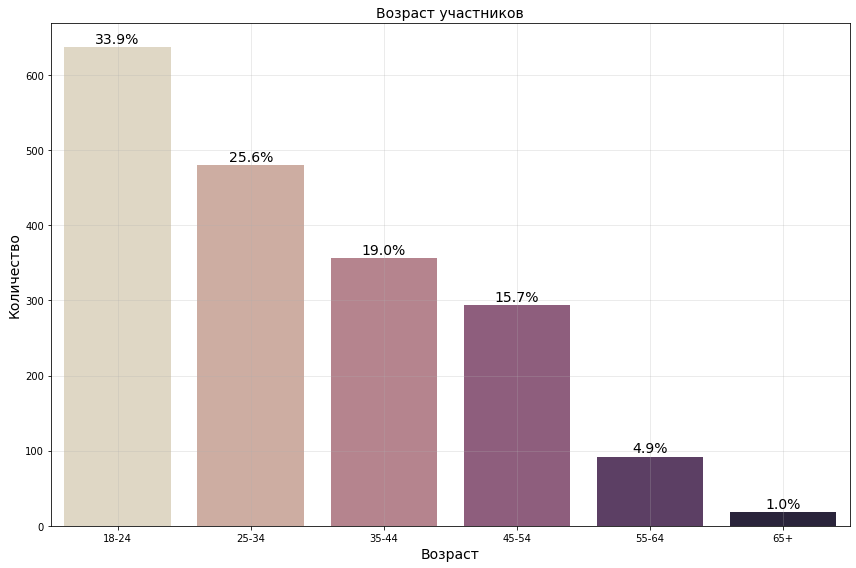

In [10]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Age'], order=df['Age'].value_counts().index, palette='ch:s=-.2,r=.6')
total = len(df['Age'])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
plt.grid(alpha=0.3)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Возраст участников', fontsize=14)
plt.tight_layout()
plt.show()

Как видно из графика, больше всего опрос прошли молодые люди. Так, немногим больше половины участников имели возраст в районе 18-34 лет.

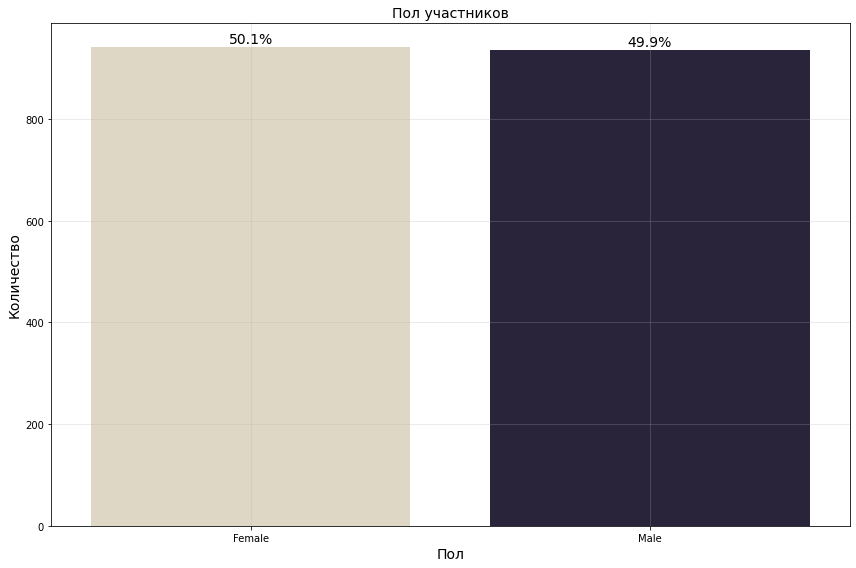

In [11]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Gender'], order=df['Gender'].value_counts().index, palette='ch:s=-.2,r=.6')
total = len(df['Gender'])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
plt.grid(alpha=0.3)
plt.xlabel('Пол', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Пол участников', fontsize=14)
plt.tight_layout()
plt.show()

В датасете репрезентативно представлен пол участвующих в опросе: половина участников - мужчины, половина - женщины.

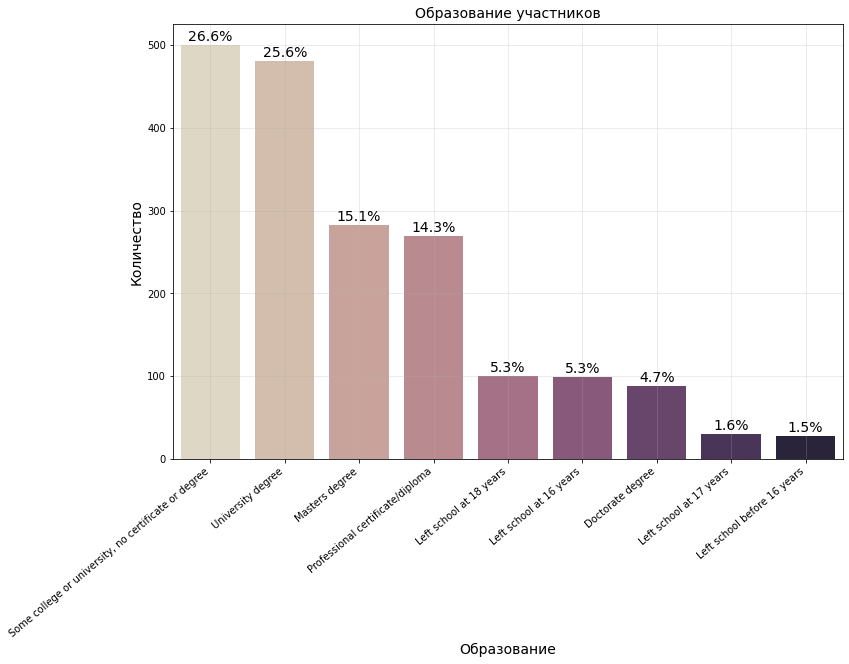

In [12]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Education'], order=df['Education'].value_counts().index, palette='ch:s=-.2,r=.6')
total = len(df['Education'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
plt.grid(alpha=0.3)
plt.xlabel('Образование', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Образование участников', fontsize=14)
plt.show()

Мы видим, что около половины участников имеют либо оконченное, либо неоконченное высшее образование. Около 14% участников бросили школу, что практически равно числу тех, кто получил профессиональные дипломы или сертификаты (в России аналог - дипломы профессиональной переподготовки).

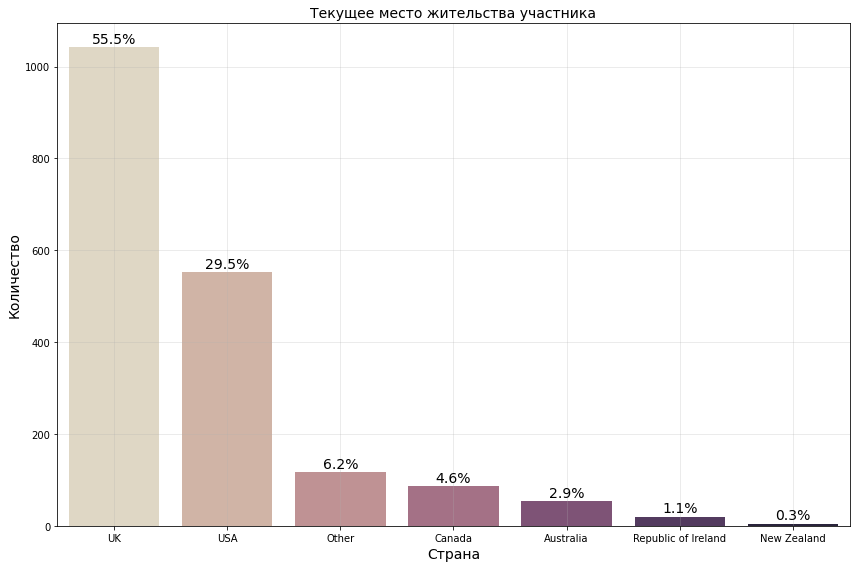

In [13]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Country'], order=df['Country'].value_counts().index, palette='ch:s=-.2,r=.6')
total = len(df['Country'])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
plt.grid(alpha=0.3)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Текущее место жительства участника', fontsize=14)
plt.tight_layout()
plt.show()

По графику заметно, что подавляющее большинство участников ($85$$\%$) опроса проживают в Великобритании и США (отсюда можно выяснить и основное место проведения опроса), также имеются несколько других стран, которые можно причислить к странам Запада.

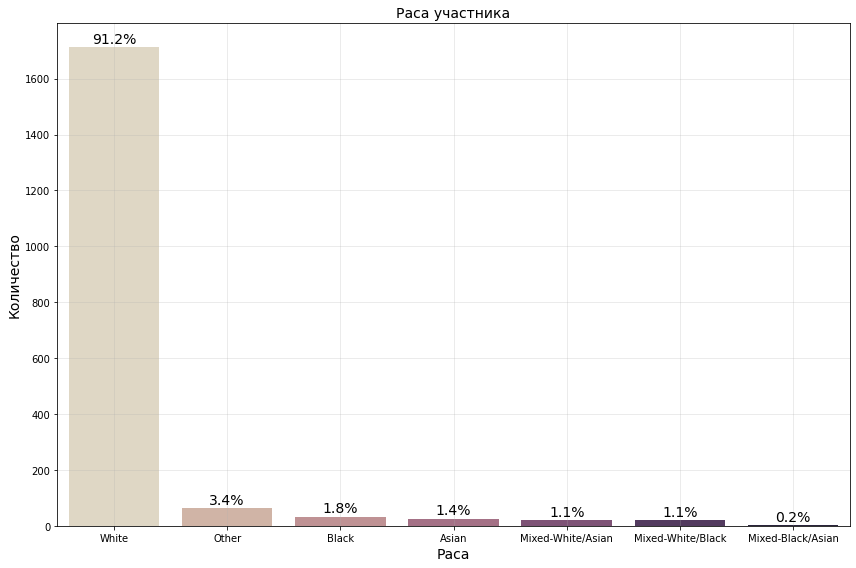

In [14]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Ethnicity'], order=df['Ethnicity'].value_counts().index, palette='ch:s=-.2,r=.6')
total = len(df['Ethnicity'])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
plt.grid(alpha=0.3)
plt.xlabel('Раса', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Раса участника', fontsize=14)
plt.tight_layout()
plt.show()

Можно отметить, что около $91$$\%$ всех опрошенных являлись белыми. То есть, в абсолютном большинстве случаев представлены результаты опросов белых, в то время как другие расы участвовали в опросе по около $1$$\%$ от всей выборки. Это, в свою очередь, может натолкнуть на идею принять данный признак как нерепрезентативный.

Составив частотные диаграммы демографических признаков датасета, можно перейти к рассмотрению того, каким образом те или иные признаки взаимодействуют друг с другом.

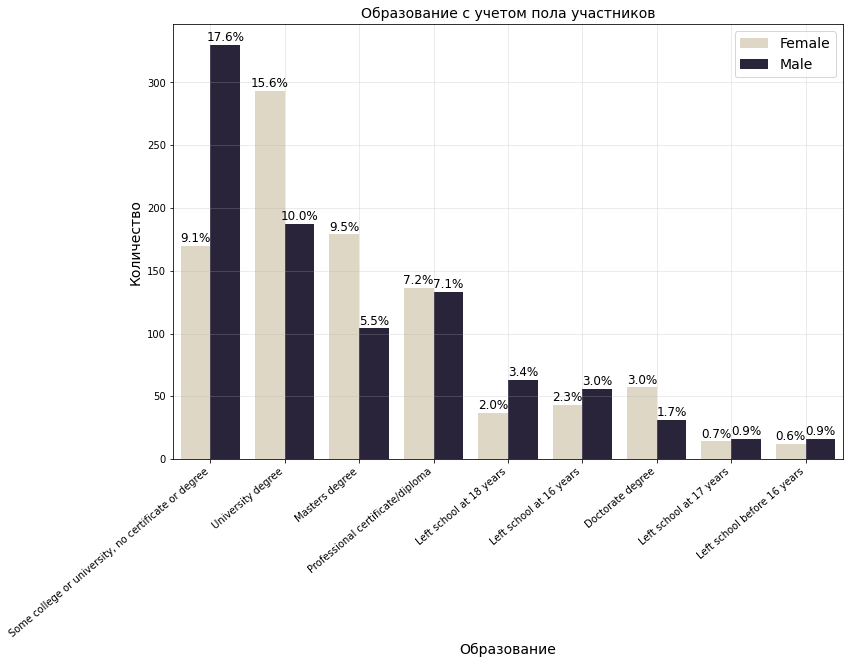

In [15]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Education'], order=df['Education'].value_counts().index, 
                   hue=df['Gender'], palette='ch:s=-.2,r=.6')
total = len(df['Education'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
    
plt.grid(alpha=0.3)
plt.xlabel('Образование', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Образование с учетом пола участников', fontsize=14)
plt.legend(fontsize=14)
plt.show()

По графику можно выявить то, что оконченное высшее образование, а также магистерскую и докторскую степень больше имеют женщины, нежели чем мужчины. В то же время, неоконченне высшее образование практически в два раза больше имеют мужчины.

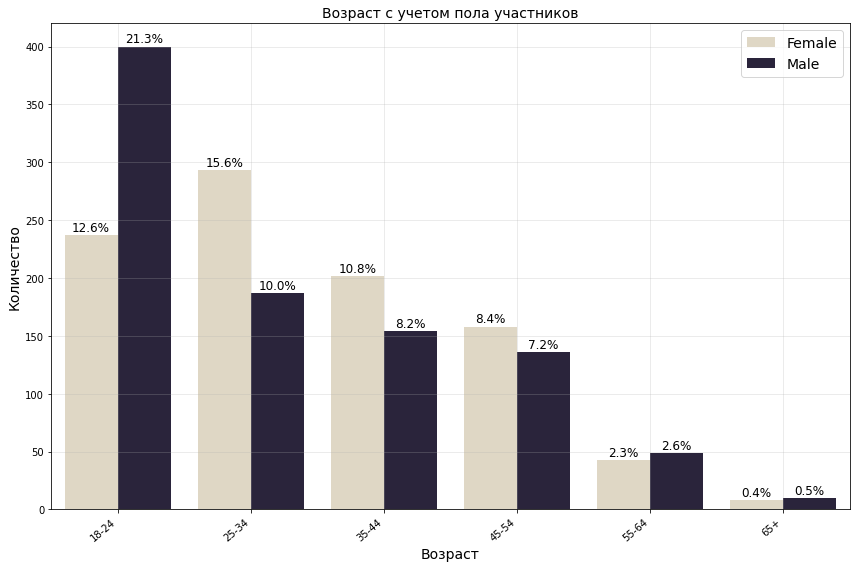

In [16]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['Age'], order=df['Age'].value_counts().index, 
                   hue=df['Gender'], palette='ch:s=-.2,r=.6')
total = len(df['Age'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
    
plt.grid(alpha=0.3)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Возраст с учетом пола участников', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

График иллюстрирует то, что в разрезе 25-54 лет в опросе приняло участие больше женщин, чем мужчин, в разрезе 55-65+ лет в целом соотношение 1 к 1. В то же время, в группе 18-24 наблюдается заметно больше мужчин.

Хотелось бы также рассмотреть то, каким образом распределились участники в разрезе пола и расы по категориям образования.

In [17]:
df.pivot_table(index='Education', columns=['Gender', 'Ethnicity'], aggfunc='size', fill_value=0)

Gender                                             Female        \
Ethnicity                                           Asian Black   
Education                                                         
Doctorate degree                                        1     0   
Left school at 16 years                                 0     0   
Left school at 17 years                                 0     0   
Left school at 18 years                                 0     0   
Left school before 16 years                             0     0   
Masters degree                                          4     6   
Professional certificate/diploma                        0     3   
Some college or university, no certificate or d...      3     2   
University degree                                       7     6   

Gender                                                                \
Ethnicity                                          Mixed-Black/Asian   
Education                                                              
Doctorate degree                                                   0   
Left school at 16 years                                            0   
Left school at 17 years                                            0   
Left school at 18 years                                            0   
Left school before 16 years                                        0   
Masters degree                                                     0   
Professional certificate/diploma                                   0   
Some college or university, no certificate or d...                 1   
University degree                                                  1   

Gender                                                                \
Ethnicity                                          Mixed-White/Asian   
Education                                                              
Doctorate degree                                                   1   
Left school at 16 years                                            0   
Left school at 17 years                                            0   
Left school at 18 years                                            0   
Left school before 16 years                                        0   
Masters degree                                                     3   
Professional certificate/diploma                                   1   
Some college or university, no certificate or d...                 2   
University degree                                                  4   

Gender                                                                      \
Ethnicity                                          Mixed-White/Black Other   
Education                                                                    
Doctorate degree                                                   2     1   
Left school at 16 years                                            0     2   
Left school at 17 years                                            1     0   
Left school at 18 years                                            0     2   
Left school before 16 years                                        0     0   
Masters degree                                                     5     5   
Professional certificate/diploma                                   0     2   
Some college or university, no certificate or d...                 1     9   
University degree                                                  2     8   

Gender                                                    Male        \
Ethnicity                                          White Asian Black   
Education                                                              
Doctorate degree                                      52     1     0   
Left school at 16 years                               41     0     0   
Left school at 17 years                               13     0     0   
Left school at 18 years                               35     0     1   
Left school before 16 ye

Как уже было констатировано ранее, подавляющее большинство участников - белые. Интересно рассмотреть другие расы. Так, например, среди темнокожих женщин большинство имеют высшее образование (лишь 2 из 17 имеют неоконченное высшее); похожая ситуация и у темнокожих мужчин - из 16 человек 11 имеют высшее образование. Та же тенденция прослеживается в той или иной степени у иных рас, отличных от белых. В целом, наиболее репрезентативно представлены белые - они охватывают все уровни образования, в то время как другие расы в основном имеют высшее образование.

###### Черты характера

Рассмотрев демографические данные, можно перейти к анализу признаков, раскрывающих черты характера участников опроса. Будем анализировать то, как влияют черты характера друг на друга, и влияют ли.

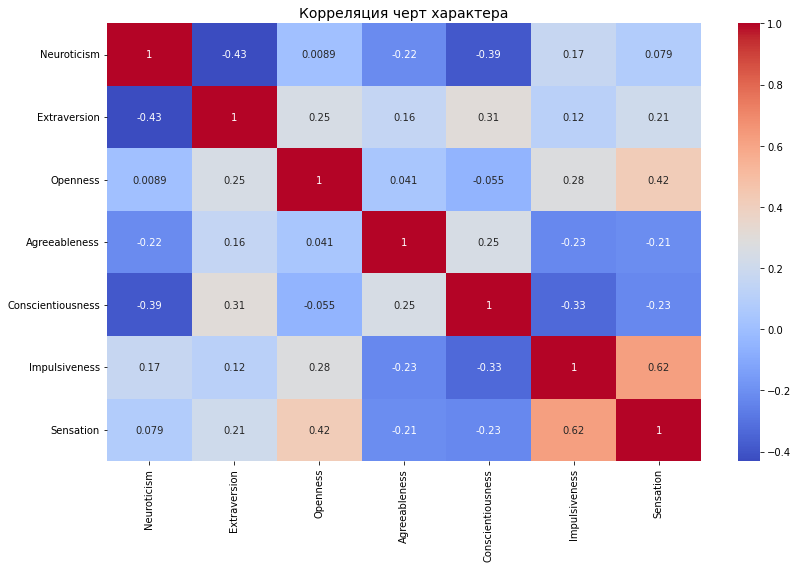

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['Neuroticism','Extraversion', 'Openness', 'Agreeableness', 
                'Conscientiousness', 'Impulsiveness', 'Sensation']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Корреляция черт характера', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
correlations = df[['Neuroticism','Extraversion', 'Openness', 'Agreeableness', 
                'Conscientiousness', 'Impulsiveness', 'Sensation']].corr().abs()

correlations = correlations[abs(correlations) >= 0.01].stack().reset_index()
correlations = correlations[correlations['level_0'].astype(str) != correlations['level_1'].astype(str)]
 
correlations['ordered-cols'] = correlations.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
correlations = correlations.drop_duplicates(['ordered-cols'])
correlations.drop(['ordered-cols'], axis=1, inplace=True)
 
correlations.sort_values(by=[0], ascending=False).reset_index().drop(columns=['index']).head(6)

,level_0,level_1,0
0,Impulsiveness,Sensation,0.622539
1,Neuroticism,Extraversion,0.430859
2,Openness,Sensation,0.422844
3,Neuroticism,Conscientiousness,0.389130
4,Conscientiousness,Impulsiveness,0.333632
5,Extraversion,Conscientiousness,0.306308


Из тепловой карты заметно, что в принципе каких-либо сильных зависимостей (корреляций) между признаками черт характера нет. В то же время, имеется одна средняя корреляция между импульсивностью и поиском ощущений. Данная корреляция может объясняться дополнительно и тем, что эти признаки в психологии достаточно похожи и порой заменяют друг друга в тестах.

Помимо этого, имеется также ряд, имеющий слабые или же слабо средние корреляции между друг другом. Так, например, невротизм и экстраверсия: данная корреляция имеет знак минус, то есть зависимость нисходящая или противоположенная. Достаточно просто объясняется, так как невротизм скорее относится к интроверсии, то есть в замкнутости в себе.

В целом же, сильных корреляций не имеется.

###### Употребление наркотических веществ

Наконец, следует перейти к рассмотрению целевых меток, представляющих собой употребление различных наркотических веществ (от легальных до нелегальных).

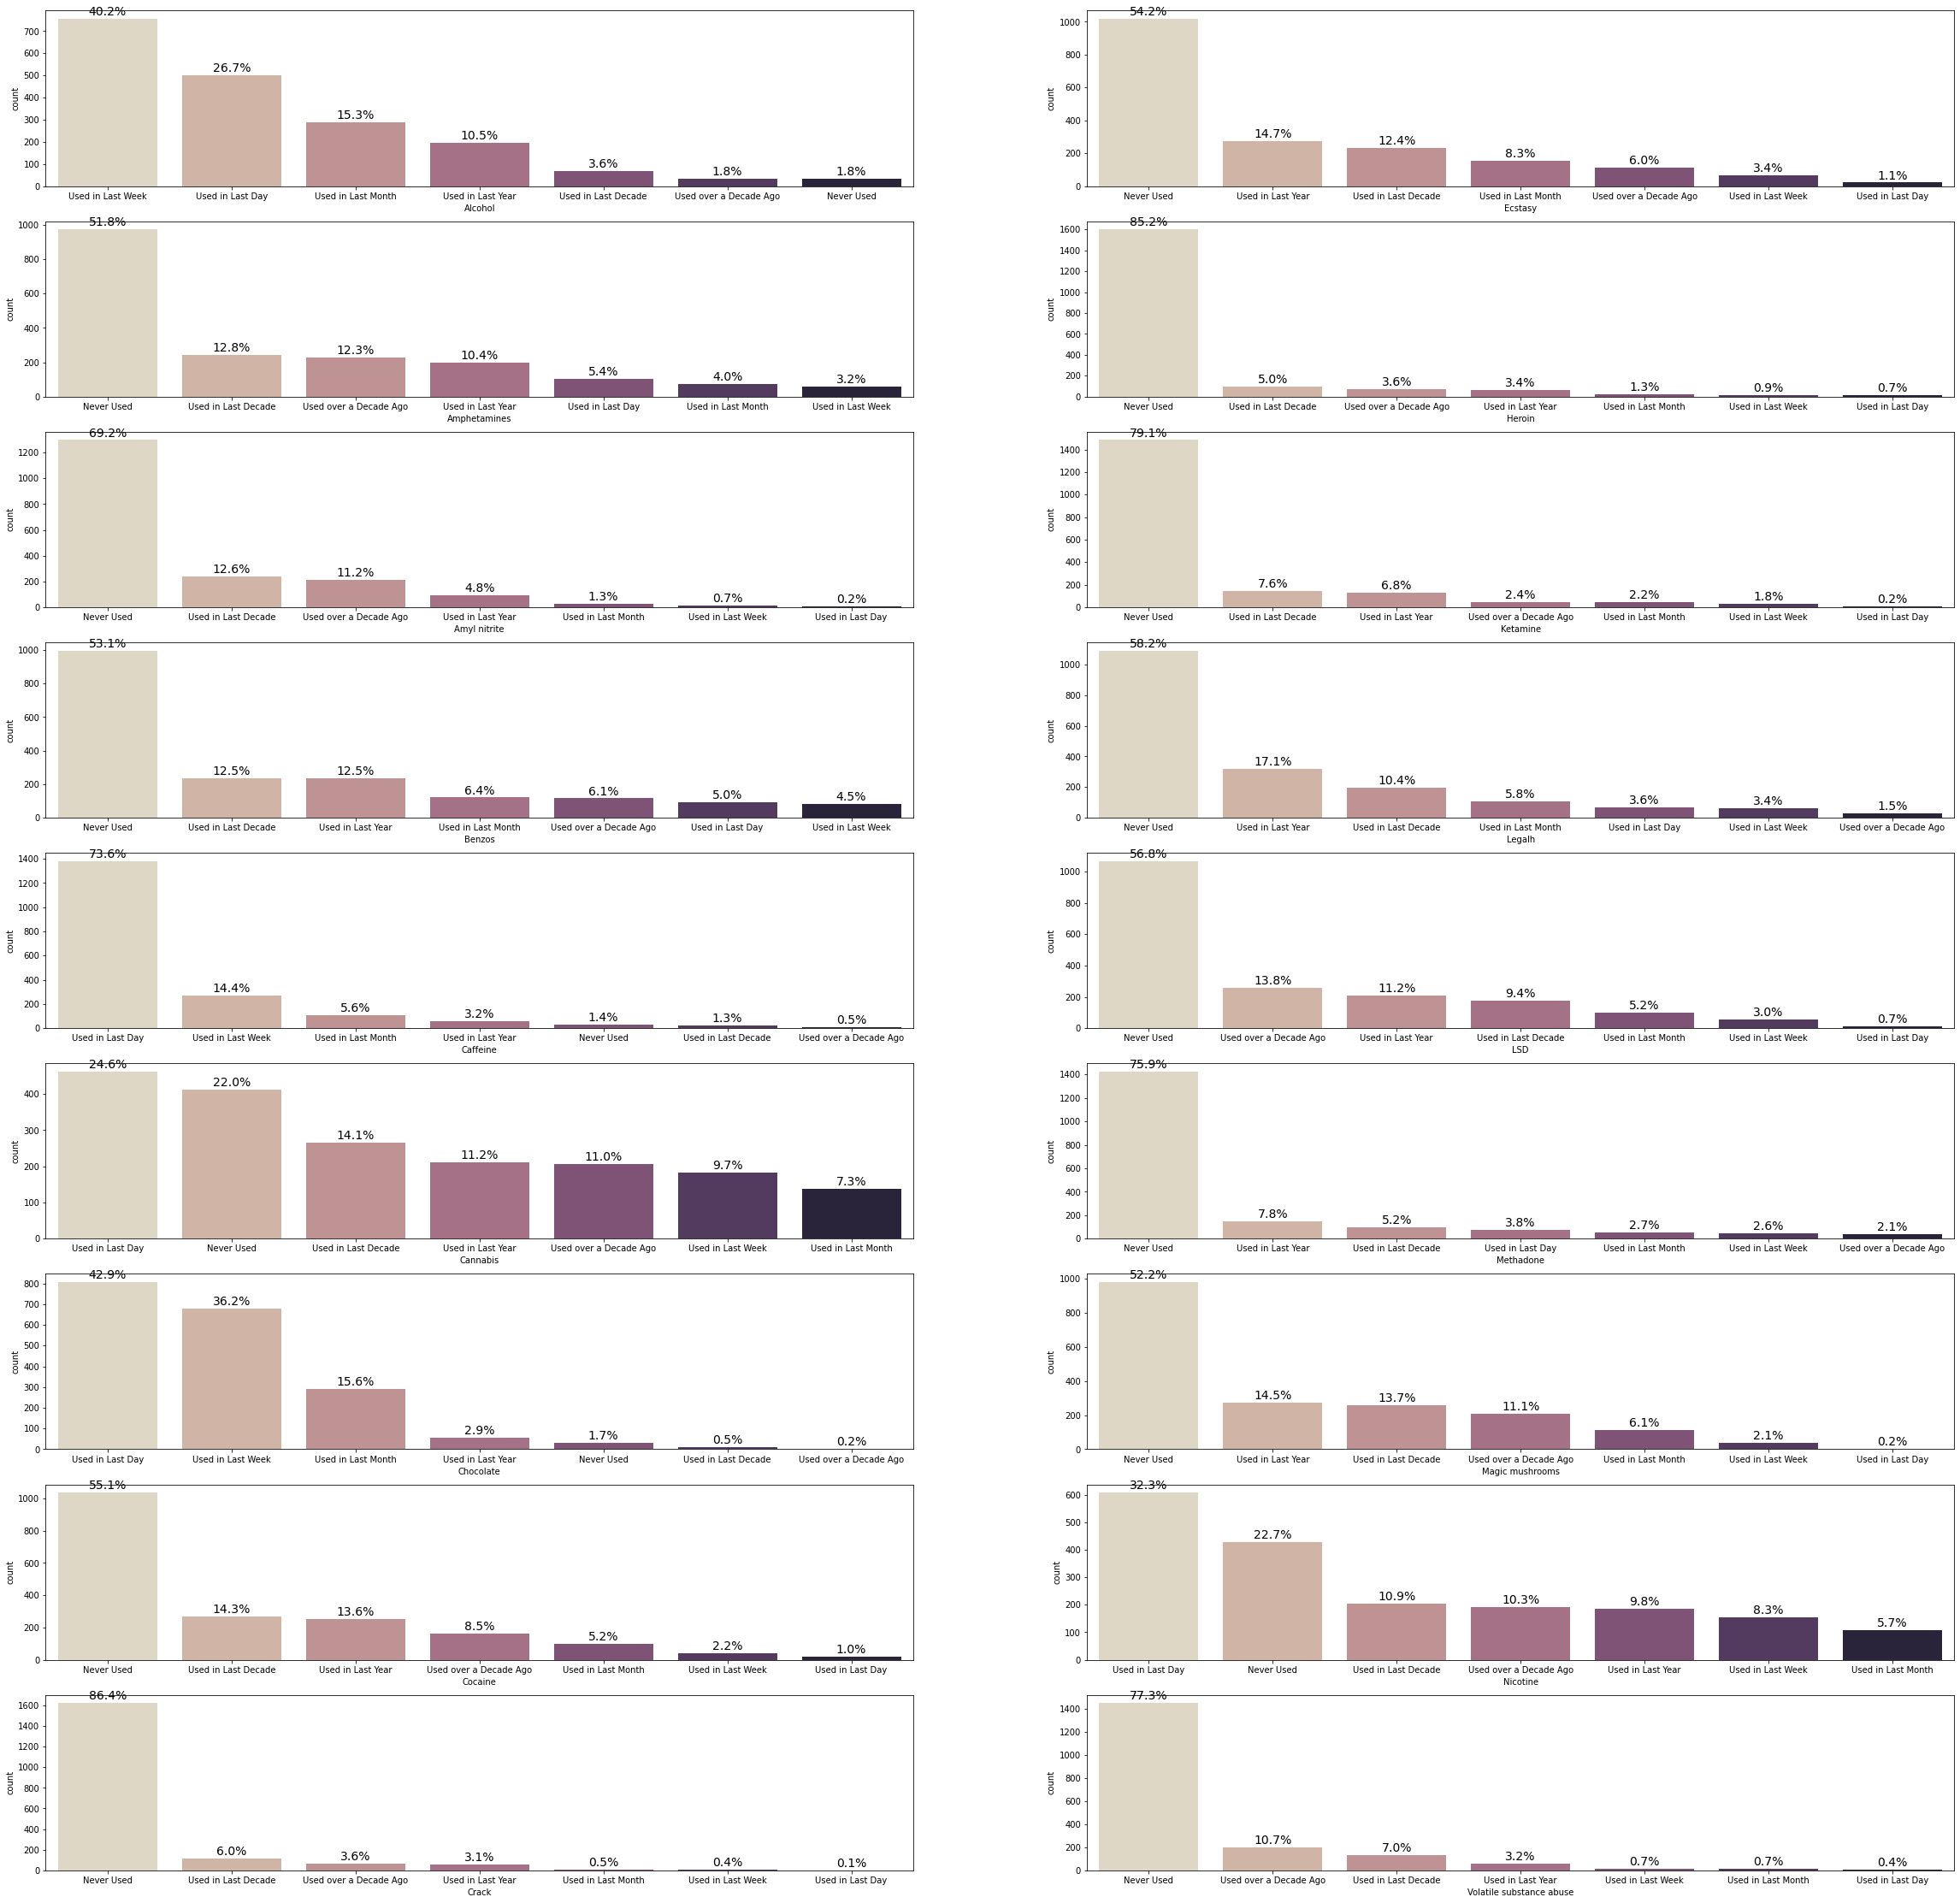

In [20]:
# для детального рассмотрения графиков, пожалуйста, откройте картинку в новой вкладке
fig, axes = plt.subplots(9, 2, figsize=(40, 40))
col = 12
for i in range(9):
    sns.countplot(ax=axes[i, 0], x=df.iloc[:, col], order=df.iloc[:, col].value_counts().index, palette='ch:s=-.2,r=.6')
    total = len(df.iloc[:, col])
    for p in axes[i, 0].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i, 0].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    col += 1
for i in range(9):
    sns.countplot(ax=axes[i, 1], x=df.iloc[:, col], order=df.iloc[:, col].value_counts().index, palette='ch:s=-.2,r=.6')
    total = len(df.iloc[:, col])
    for p in axes[i, 1].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i, 1].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    col += 1

Интереснее рассмотреть подробнее графики потребления "легальных" наркотиков (кофеин, никотин, алкоголь, шоколад). Запрещенные наркотики будут рассмотрены позднее в рамках исследования участников, употреблявших и не употреблявших наркотические вещества.

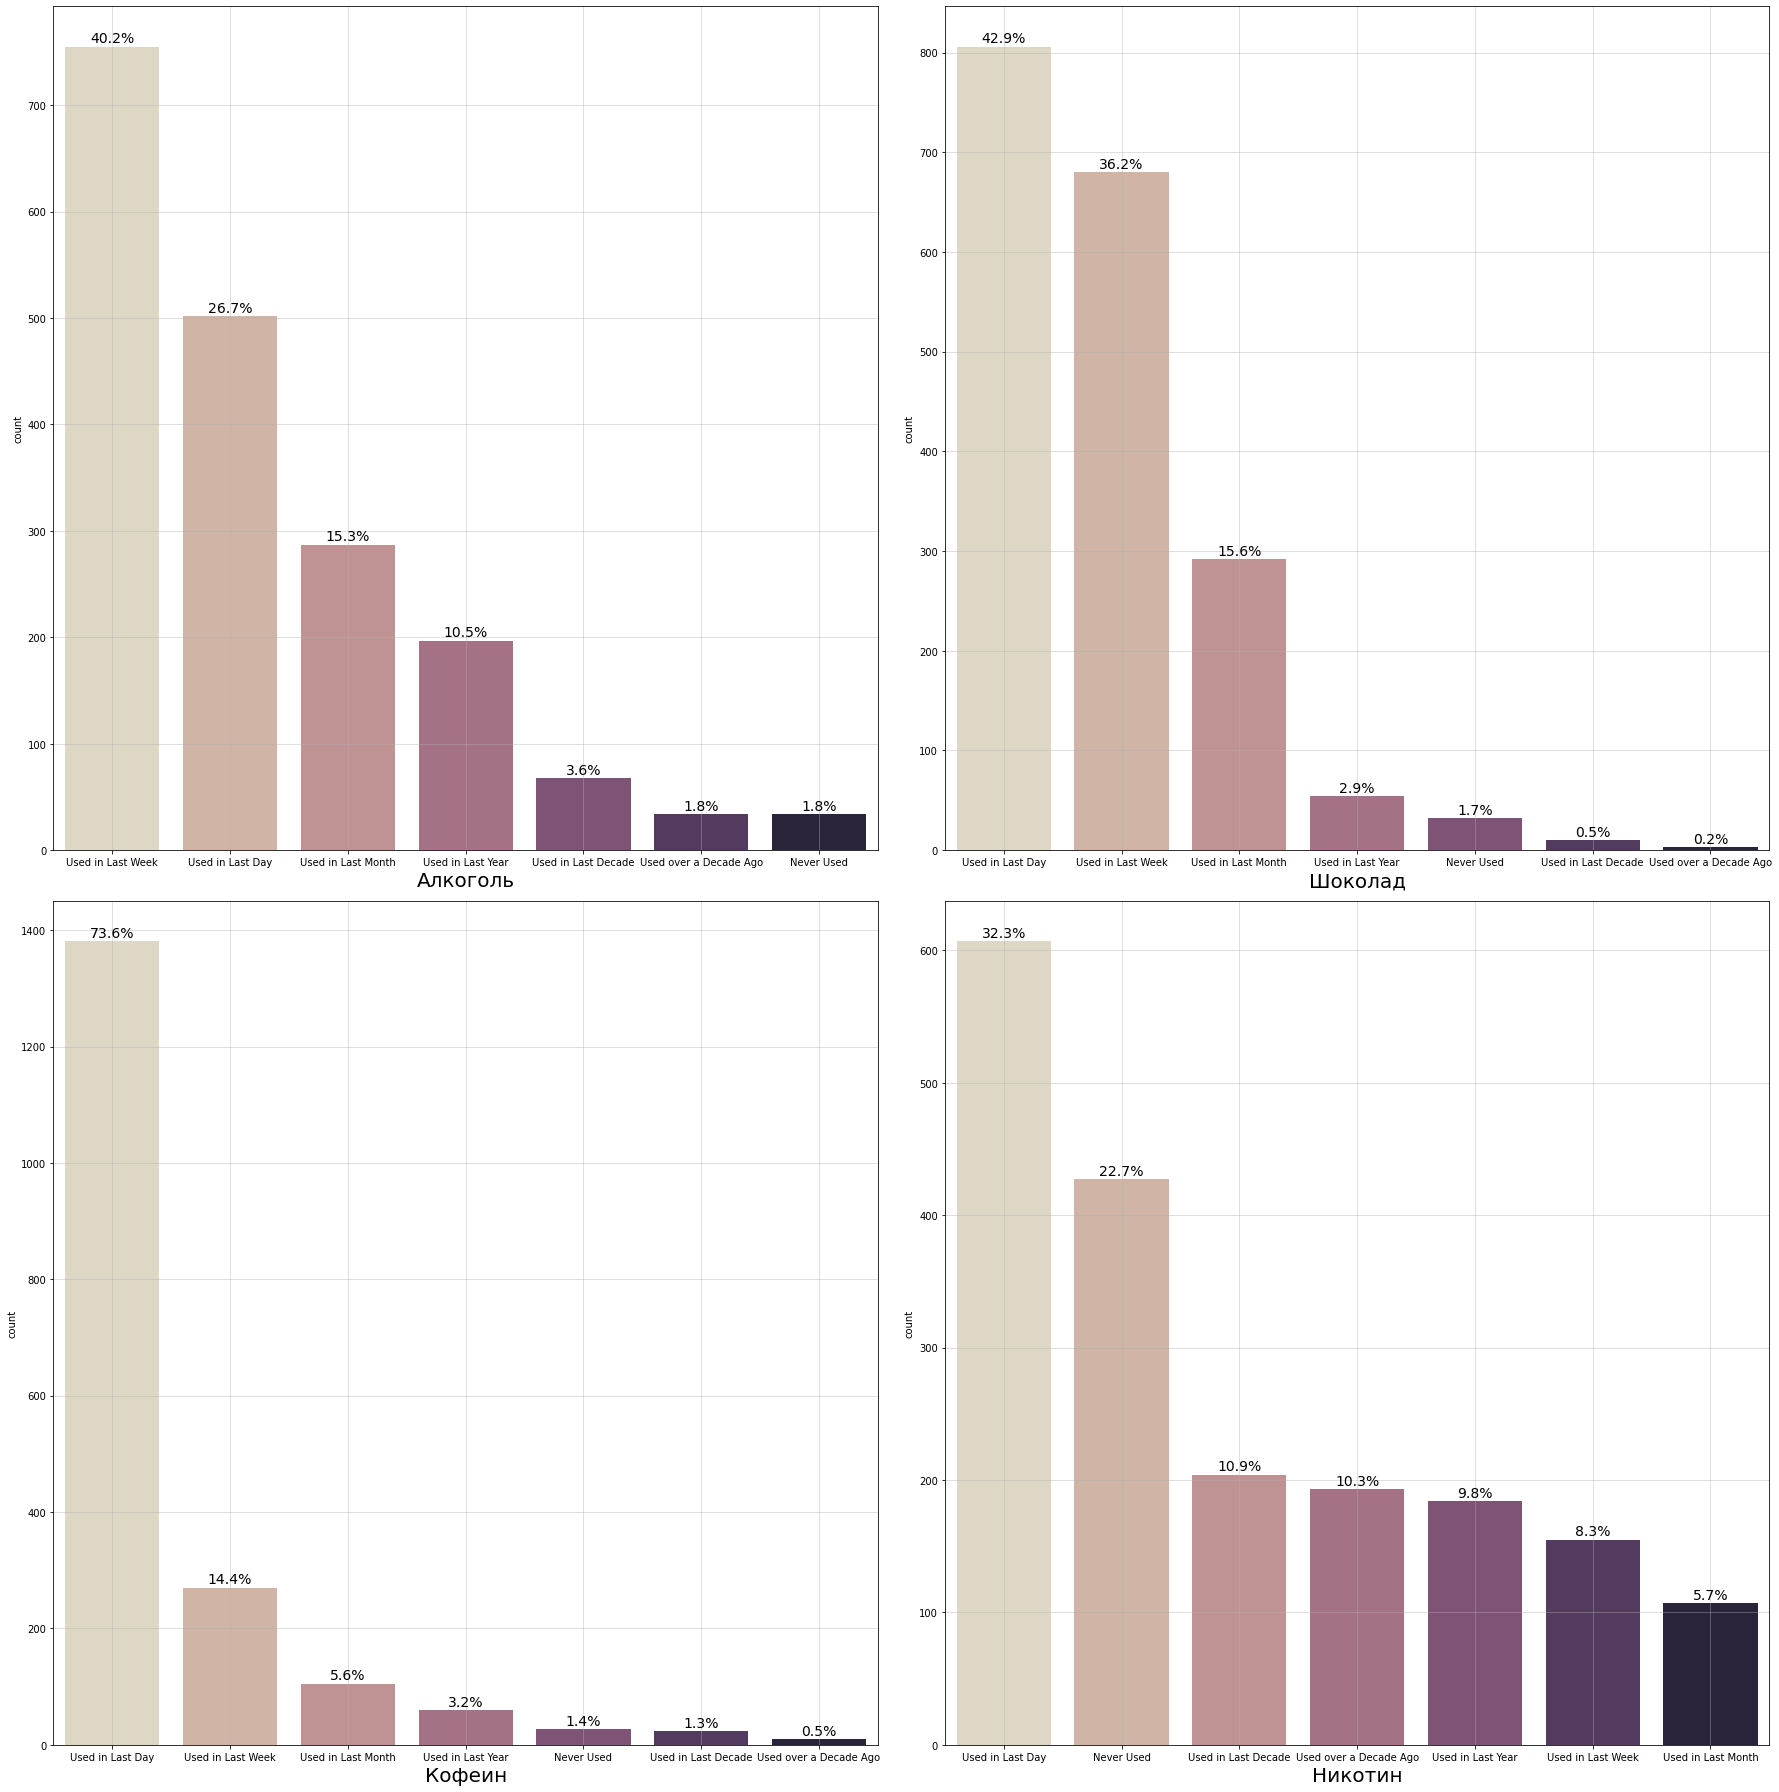

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(25, 25))
sns.countplot(ax=axes[0, 0], x=df['Alcohol'], order=df['Alcohol'].value_counts().index, palette='ch:s=-.2,r=.6')
axes[0, 0].set_xlabel('Алкоголь', fontsize=20)
axes[0, 0].grid(alpha=0.5)
total = len(df['Alcohol'])
for p in axes[0, 0].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 0].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
sns.countplot(ax=axes[1, 0], x=df['Caffeine'], order=df['Caffeine'].value_counts().index, palette='ch:s=-.2,r=.6')
axes[1, 0].set_xlabel('Кофеин', fontsize=20)
axes[1, 0].grid(alpha=0.5)
total = len(df['Caffeine'])
for p in axes[1, 0].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[1, 0].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
sns.countplot(ax=axes[0, 1], x=df['Chocolate'], order=df['Chocolate'].value_counts().index, palette='ch:s=-.2,r=.6')
axes[0, 1].set_xlabel('Шоколад', fontsize=20)
axes[0, 1].grid(alpha=0.5)
total = len(df['Chocolate'])
for p in axes[0, 1].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 1].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    
sns.countplot(ax=axes[1, 1], x=df['Nicotine'], order=df['Nicotine'].value_counts().index, palette='ch:s=-.2,r=.6')
axes[1, 1].set_xlabel('Никотин', fontsize=20)
axes[1, 1].grid(alpha=0.5)
total = len(df['Nicotine'])
for p in axes[1, 1].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[1, 1].annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
fig.tight_layout()

Из графиков можно сделать следующие выводы о "легальных" наркотиках:
- кофеин доминирует по частоте употребления ($73.6$$\%$ пили кофе вчера, а за неделю кофе пили $88$$\%$ участников, то есть подавляющее большинство)
- шоколад оказывается вторым наиболее употребляемым ($42.9$$\%$ опрошенных ели его за прошедший день, а если посчитать включая прошедшую неделю, то данный показатель вырастет до $79.1$$\%$)
- алкоголь занимает третье место по частоте употребления (всего $26.7$$\%$ пили его за прошедший день, но включая тех, кто пил его за прошедшую неделю, алкоголь принимали $66.9$$\%$ опрошенных; другими словами, превалирует тенденция принимать алкоголь раз в неделю или с еще меньшей частотой, что отличает данный наркотик от кофеина и шоколада)
- никотин наименее популярен среди четырех "легальных" наркотиков ($32.3$$\%$ курили за прошедший день, а если посчитать за прошедшую неделю, то выйдет, что курили за это время только $40.6$$\%$, то есть меньше половины опрошенных; помимо этого, у данного наркотика более всего выражены варианты "Употреблял в прошедшем десятилетии" и "Употреблял более десяти лет назад")

Теперь хотелось бы рассмотреть употребление данных наркотиков более обобщенно. Так, разобъем ответы на две обобщенные группы: в первом группе находятся "потребители" наркотиков, то есть те, которые за определенный промежуток времени принимали данное вещество; во второй группе находятся "не-потребители" наркотиков, то есть те, которые за определенный промежуток времени не принимали данное вещество. 

Возьмем два промежутка времени: сначала рассмотрим, кто является потребителем наркотических веществ за год (то есть тот, кто ответил, что принимал данное вещество максимум в прошлом десятилетии, будет считаться не-потребителем); затем рассмотрим, кто является потребителем наркотических веществ за десятилетие ( то есть тот, кто ответил, что принимал данное вещество максимум более десяти лет назад, будет считаться не-потребителем).

In [22]:
drugs = df.iloc[:, 12:30]
consumer_year = pd.DataFrame(np.where(
    np.logical_or(np.logical_or(
        drugs == 'Never Used', 
        drugs == 'Used over a Decade Ago'), 
        drugs == 'Used in Last Decade'), 'Non-consumer', 'Consumer'), 
                             columns=['Alcohol', 'Amphetamines', 'Amyl nitrite', 
                                      'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 
                                      'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Methadone', 'Magic mushrooms', 'Nicotine', 
                                      'Volatile substance abuse'])
consumer_decade = pd.DataFrame(np.where(
    np.logical_or(drugs == 'Never Used', drugs == 'Used over a Decade Ago'), 'Non-consumer', 'Consumer'),
                              columns=['Alcohol', 'Amphetamines', 'Amyl nitrite', 
                                       'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 
                                       'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Methadone', 'Magic mushrooms', 'Nicotine', 
                                       'Volatile substance abuse'])

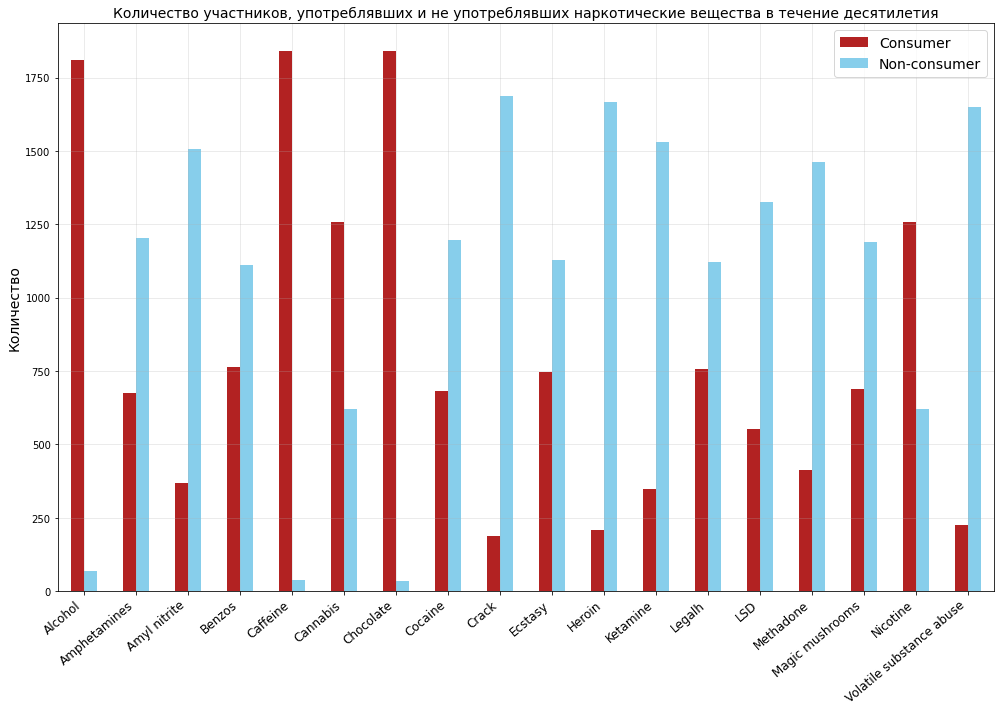

In [23]:
grouped_consumer_decade = pd.DataFrame()
for drug in drugs:
    grouped_consumer_decade = pd.concat([grouped_consumer_decade, consumer_decade.groupby(drug).size()], axis=1)
grouped_consumer_decade.columns = drugs.columns

grouped_consumer_decade.T.plot.bar(color=['firebrick', 'skyblue'], figsize=(14,10))
plt.xticks(rotation=40, ha="right", fontsize=12)
plt.grid(alpha=0.3)
plt.ylabel('Количество', fontsize=14)
plt.title('Количество участников, употреблявших и не употреблявших наркотические вещества в течение десятилетия', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Заметно, что наиболее всего употребляются как раз "легальные" наркотики: в случае с алкоголем, кофеином и шоколадом подавляющее большинство участников опроса в течение десятилетия употребляло данные вещества.

Среди наиболее популярных за десятилетие "нелегальных" наркотиков можно выделить следующие: самый популярный - марихуана, который разрешен для употребления в качестве медикамента в ряде стран, поэтому, возможно, в данном датасете марихуану употребили практически столько же человек, сколько и никотин за десятилетие; после идет бензодиазепин, а за ним привычные наркотики: экстази, "legal highs", кокаин и "магические грибы". 

Наименее употребляемыми за десятилетие наркотиками стали: крэк, героин, а также, как явление, токсикомания. 

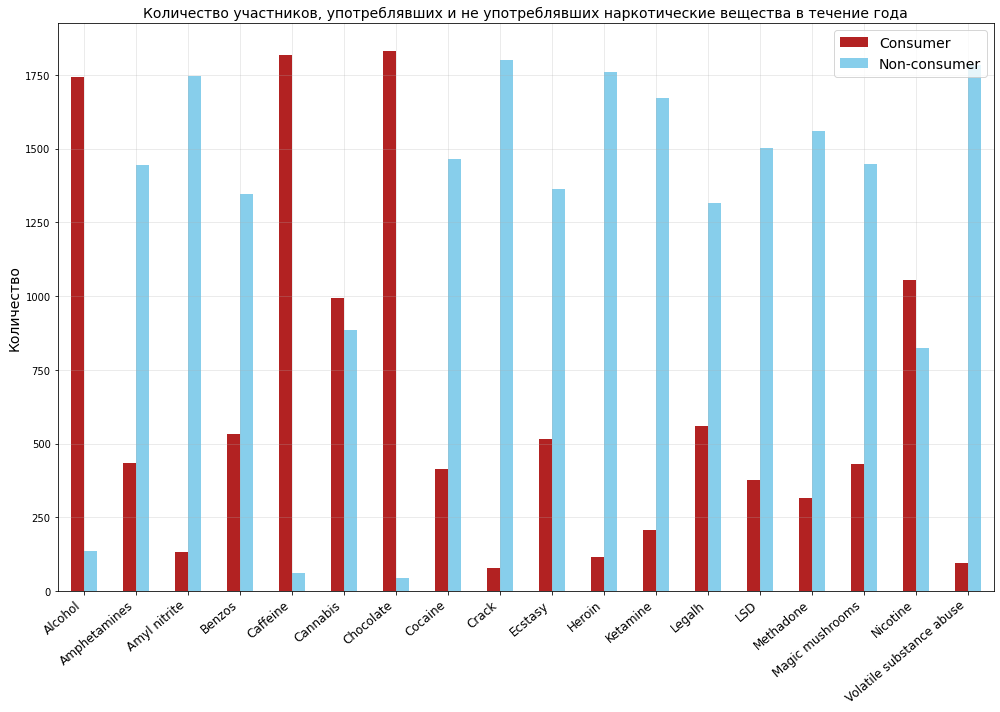

In [24]:
grouped_consumer_year = pd.DataFrame()
for drug in drugs:
    grouped_consumer_year = pd.concat([grouped_consumer_year, consumer_year.groupby(drug).size()], axis=1)
grouped_consumer_year.columns = drugs.columns

grouped_consumer_year.T.plot.bar(color=['firebrick', 'skyblue'], figsize=(14,10))
plt.xticks(rotation=40, ha="right", fontsize=12)
plt.grid(alpha=0.3)
plt.ylabel('Количество', fontsize=14)
plt.title('Количество участников, употреблявших и не употреблявших наркотические вещества в течение года', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Видно, что за год по сравнению с десятилетием картина в целом не меняется. Все также подавляющее число опрошенных употребляли алкоголь, кофеин и шоколад. Немного более смещенным к центру стало разделение тех, кто употреблял и не употреблял никотин, как и в случае с марихуаной (все еще остается больше тех, кто употреблял). 

Однако, к наиболее употребляемым "нелегальным" наркотикам добавился амфетамин.

В целом же, графики в остальном довольно-таки похожи.

Мы проанализировали датасет, рассмотрели различные признаки и их корреляцию друг с другом, а также разобрали целевые метки. Теперь представляется возможным перейти к решению задачи классификации.

### Переход к multilabel classification

###### Преобразование датасета

Для начала, следует преобразовать категориальные признаки в датасете, чтобы они правильно читались моделью. Также нужно немного видоизменить сами целевые метки: сократить их до двух и перевести в формат 0 или 1.

In [25]:
# Деление на признаки и целевые переменные
X = data.drop(data.columns[np.arange(12, 30, 1)], axis=1)
y = data.iloc[:, 12:30]

In [26]:
# форматирование вещественных чисел в признаках в string
# для более адекватного последующего преобразования категориальных признаков
X = X.astype(str)
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.6209,-1.0145,-1.37983,0.40148
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.6334,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


Не смотря на то, что признаков достаточно много, как и уникальных значений у каждого признака, в данной работе будут использоваться все признаки для обучения. Перейдем к кодированию категориальных признаков.

В датасете есть несколько признаков, а именно возраст и образование, которые не смотря на то, что являются категориальными, имеют определенный порядок. Потому, к двум данным признакам будет применено порядковое кодирование. 

In [27]:
ordinal_enc = OrdinalEncoder()
X_ordinal = np.vstack((X.iloc[:, 0], X.iloc[:, 2])).T
X = X.drop(X.columns[0], axis=1)
X = X.drop(X.columns[1], axis=1)
X_ordinal = ordinal_enc.fit_transform(X_ordinal)

In [28]:
X_ordinal.shape

(1877, 2)

In [29]:
enc = OneHotEncoder()
X_categorized = enc.fit_transform(X).toarray()

In [30]:
X_categorized = np.hstack((X_ordinal, X_categorized))
X = pd.DataFrame(X_categorized)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Признаки были надлежащим образом закодированы, далее перейдем к изменению целевых меток.

Как было предложено в описании датасета, изменение целевых меток будет произведено следующим образом:
- Метки "CL0 - Never Used" и "CL1 - Used over a Decade Ago" можно обозначить как "Non-user" или 0
- Остальные метки можно обозначить как "User" или 1

In [31]:
y = pd.DataFrame(np.where(np.logical_or(y == 'CL0', y == 'CL1'), 0, 1))
y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0


###### Обучение и валидация модели

Теперь, когда датасет готов для передачи на обучение и тест модели, можно перейти к обозначению тестируемых моделей и к стратегии кросс-валидации.

В рамках данной работы будет использоваться библиотека sklearn, в которой для решения задач multilabel (multioutput) классификаций имеются свои собственные функции. Это _MultiOutputClassifier_ и _ClassifierChain_. Первая строит классификатор для каждой целевой метки независимо, вторая же учитывает предсказания каждого предыдущего классификатора. 

Вышеназванные функции требуют на вход классификатор, который и будет выполнять основную работу. Для начала взят случайный лес для отбора оптимальной функции, далее же будет происходить отбор различных базовых классификаторов для последующего подбора оптимальных параметров.

Так как для данного вида задач стандартная метрика не подходит, будет создана своя собственная. Это взвешенная F-мера, то есть учитывающая соотношение классов внутри каждой метки $y$. Помимо этого, использован дополнительный параметр _zero_division_, который будет возвращать 0 или 1 в случае, если при подсчете F-меры возникает деление на 0 (при классификации модель видела только один класс, что возможно).

In [32]:
scorer = make_scorer(f1_score, average='weighted', zero_division=1)

Для поиска оптимальной для задачи функции multilabel классификации сравним их результат на кросс-валидации на 5 фолдов. 

In [33]:
random_forest = RandomForestClassifier()
score_moc = cross_val_score(MultiOutputClassifier(random_forest), X, y, scoring=scorer, cv=5)
score_cc = cross_val_score(ClassifierChain(random_forest), X, y, scoring=scorer, cv=5)

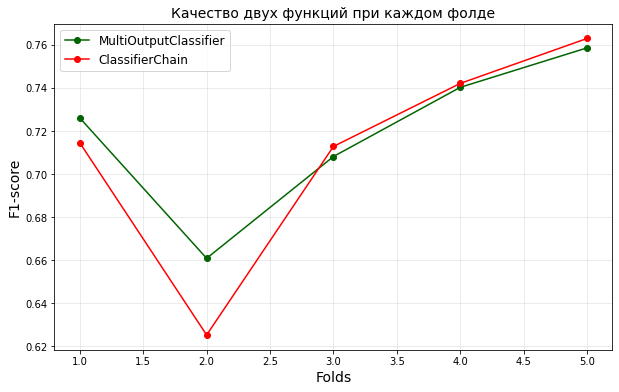

In [34]:
x = range(1, 6)
plt.figure(figsize=(10,6))
plt.plot(x, score_moc, marker='o', color='darkgreen')
plt.plot(x, score_cc, marker='o', color='red')
plt.grid(alpha=0.3)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Качество двух функций при каждом фолде', fontsize=14)
plt.legend(['MultiOutputClassifier', 'ClassifierChain'], fontsize=12)
plt.show()

In [35]:
print(f'Среднее значение качества у MultiOutputClassifier: {round(score_moc.mean(), 4)}')
print(f'Среднее значение качества у ClassifierChain: {round(score_cc.mean(), 4)}')

Среднее значение качества у MultiOutputClassifier: 0.7188
Среднее значение качества у ClassifierChain: 0.7115


Таким образом, не смотря на то, что на некоторых фолдах две функции получили практически идентичные метрики качества, _ClassifierChain_ показал несколько более низкие результаты, поэтому в последующем будет использоваться _MultiOutputClassifier_.

Теперь перейдем к выбору наилучшего классификатора.

Выбор будет происходить между распространенными классификаторами (с параметрами по умолчанию), которые зарекомендовали себя положительно: случайный лес, метод опорных векторов, классификация при помощи стохастического градиентного спуска, и K-соседей.

In [36]:
classifiers = [SGDClassifier(), KNeighborsClassifier(), SVC(), RandomForestClassifier()]
scores = []
for clf in classifiers:
    score = cross_val_score(MultiOutputClassifier(clf), X, y, scoring=scorer, cv=5)
    scores.append((clf, score))

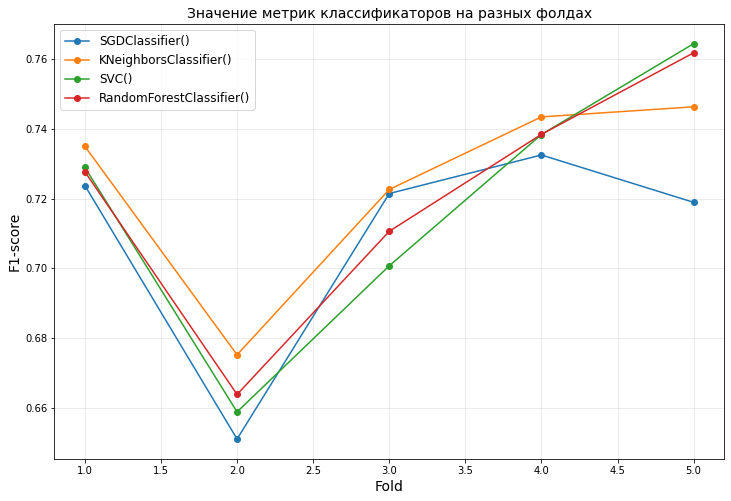

In [37]:
plt.figure(figsize=(12,8))
for score in scores:
    plt.plot(x, score[1], marker='o')
plt.xlabel('Fold', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.legend([str(score[0]) for score in scores], fontsize=12)
plt.title('Значение метрик классификаторов на разных фолдах', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [38]:
for score in scores:
    print(f'Среднее значение {score[0]}: {round(score[1].mean(), 4)}')

Среднее значение SGDClassifier(): 0.7095
Среднее значение KNeighborsClassifier(): 0.7245
Среднее значение SVC(): 0.7182
Среднее значение RandomForestClassifier(): 0.7205


В общем, хорошее среднее значение принимают все классификаторы. Далее можно подробнее подобрать параметры к каждому из них так, чтобы посмотреть, получится ли добиться еще более лучшего результата.

_SGDClassifier_

In [39]:
parameters = {
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__alpha': [val for val in np.arange(0.0001, 0.0012, 0.0005)],
    'estimator__class_weight': [None, 'balanced']
}
clf_sgd = RandomizedSearchCV(estimator=MultiOutputClassifier(SGDClassifier()), 
                             param_distributions=parameters, scoring=scorer, cv=5)
clf_sgd.fit(X, y)

c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=SGDClassifier()),
                   param_distributions={'estimator__alpha': [0.0001,
                                                             0.0006000000000000001,
                                                             0.0011],
                                        'estimator__class_weight': [None,
                                                                    'balanced'],
                                        'estimator__loss': ['hinge',
                                                            'squared_hinge'],
                                        'estimator__penalty': ['l2', 'l1']},
                   scoring=make_scorer(f1_score, average=weighted, zero_division=1))

Итоговые параметры после рандомизированного поиска по сетке:

In [40]:
clf_sgd.best_params_

{'estimator__penalty': 'l2',
 'estimator__loss': 'hinge',
 'estimator__class_weight': 'balanced',
 'estimator__alpha': 0.0006000000000000001}

In [41]:
MultiOutputClassifier(estimator=SGDClassifier(penalty='l1', class_weight='balanced', alpha=0.0006))
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_sgd.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7229


Таким образом, удалось немного, но увеличить качество модели на валидации.

_SVC_

In [42]:
parameters = {
    'estimator__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}
clf_svc = GridSearchCV(estimator=MultiOutputClassifier(SVC(class_weight='balanced')), 
                             param_grid=parameters, scoring=scorer, cv=5)
clf_svc.fit(X, y)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=SVC(class_weight='balanced')),
             param_grid={'estimator__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring=make_scorer(f1_score, average=weighted, zero_division=1))

Итоговые параметры метода опорных векторов после поиска по сетке:

In [43]:
clf_svc.best_params_

{'estimator__C': 2.0}

In [44]:
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_svc.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7602


Видно, что, по сути, качество намного увеличилось за счет указания сбалансированного веса классов в параметрах SVC, параметр регуляризации C немного увеличился от стандартного.

Более того, качество SVC оказалось даже лучше, чем показатель у SGD.

_RandomForestClassifier_

In [45]:
parameters = {
    'estimator__n_estimators': [100, 250, 500],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__class_weight': [None, 'balanced', 'balanced_subsample']
}
clf_rfc = RandomizedSearchCV(estimator=MultiOutputClassifier(RandomForestClassifier()), 
                             param_distributions=parameters, scoring=scorer, cv=5)
clf_rfc.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier()),
                   param_distributions={'estimator__class_weight': [None,
                                                                    'balanced',
                                                                    'balanced_subsample'],
                                        'estimator__criterion': ['gini',
                                                                 'entropy'],
                                        'estimator__n_estimators': [100, 250,
                                                                    500]},
                   scoring=make_scorer(f1_score, average=weighted, zero_division=1))

In [46]:
clf_rfc.best_params_

{'estimator__n_estimators': 250,
 'estimator__criterion': 'gini',
 'estimator__class_weight': 'balanced_subsample'}

In [47]:
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_rfc.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7298


Получается, что Случайный лес все-таки проигрывает подогнанному классификатору метода опорных векторов. Тем не менее, немного, но результат улучшился по сравнению со стандартными параметрами.

_KNeighborsClassifier_

In [48]:
parameters = {
    'estimator__n_neighbors': [3, 5, 10, 20],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]
}
clf_knc = GridSearchCV(estimator=MultiOutputClassifier(KNeighborsClassifier()), 
                             param_grid=parameters, scoring=scorer, cv=5)
clf_knc.fit(X, y)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': [3, 5, 10, 20],
                         'estimator__p': [1, 2],
                         'estimator__weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, average=weighted, zero_division=1))

In [49]:
clf_knc.best_params_

{'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

In [50]:
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_knc.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7245


Поиск параметров не дал иных результатов у K-соседей. Возможно, что качество можно было бы изменить, взяв иную метрику, нежели чем Миньковского, но на это нужно больше времени и еще больше параметров.

Теперь можно также рассмотреть то, каким образом данные 4 классификатора обучаются.

In [51]:
train_sizes, train_scores, test_scores = learning_curve(
    MultiOutputClassifier(estimator=SGDClassifier(
        penalty='l2', class_weight=None, alpha=0.0011, max_iter=5000)),
    X, y, cv=5, scoring=scorer)

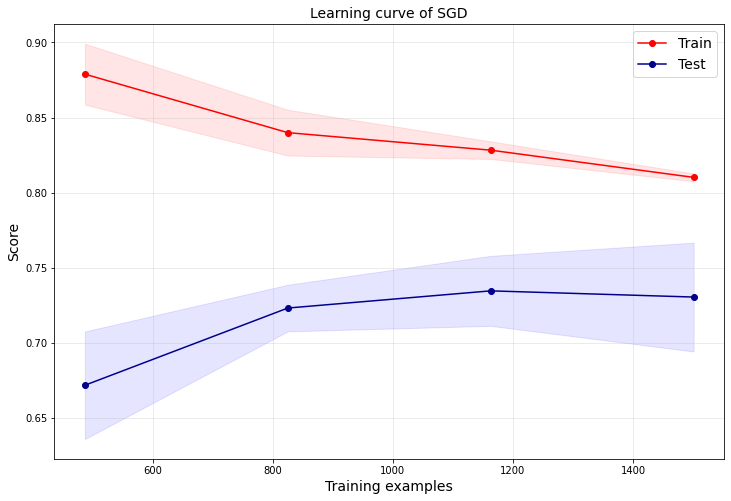

In [52]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of SGD', fontsize=14)
plt.show()

In [53]:
train_sizes, train_scores, test_scores = learning_curve(MultiOutputClassifier(SVC(
    C=2.0, class_weight='balanced')), X, y, cv=5, scoring=scorer)

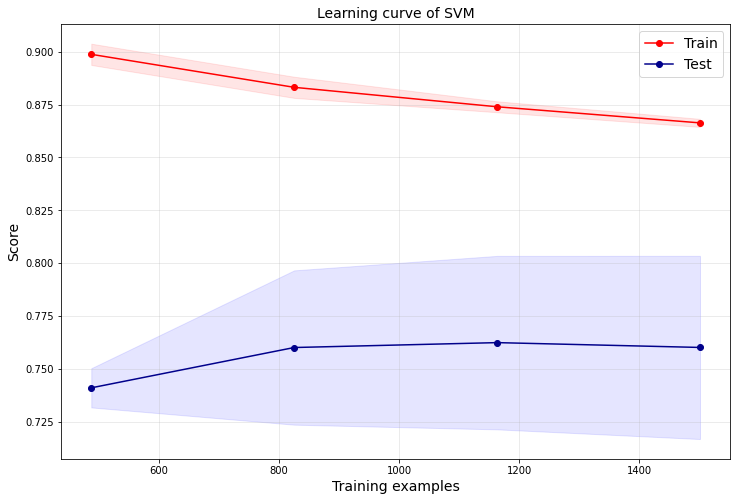

In [54]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of SVM', fontsize=14)
plt.show()

In [55]:
train_sizes, train_scores, test_scores = learning_curve(
    MultiOutputClassifier(estimator=RandomForestClassifier(
        n_estimators=500, class_weight='balanced', criterion='gini')),
    X, y, cv=5, scoring=scorer)

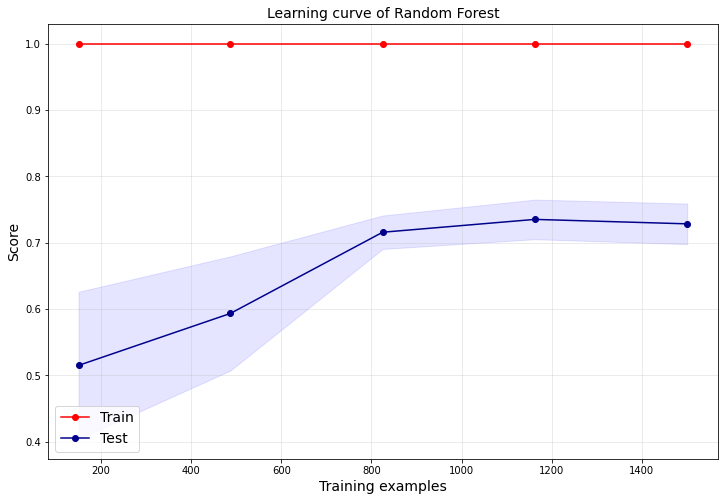

In [56]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of Random Forest', fontsize=14)
plt.show()

In [57]:
train_sizes, train_scores, test_scores = learning_curve(
    MultiOutputClassifier(estimator=KNeighborsClassifier(
        n_neighbors=5, p=2, weights='uniform')),
    X, y, cv=5, scoring=scorer)

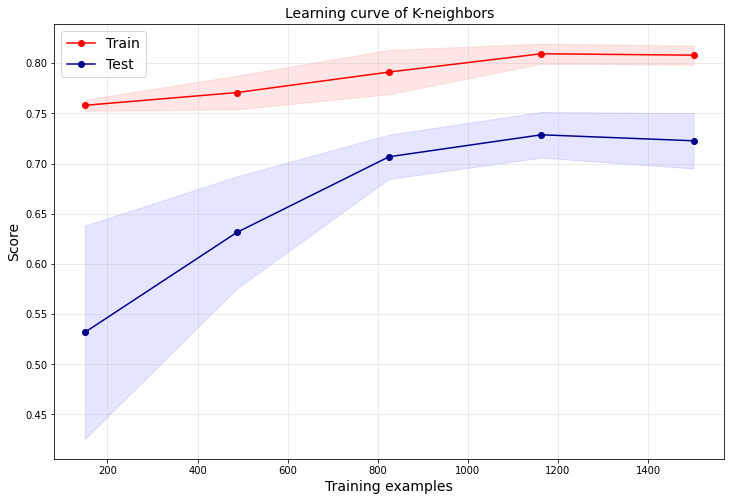

In [58]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of K-neighbors', fontsize=14)
plt.show()

В итоге, удалось реализовать задачу multiclass multilabel классификации при помощи ее сведения к multilabel binary классификации. Наилучшие результаты метрики качества, подогнанной под задачу, показал метод опорных векторов.